# Celltype Classification with Transcriptformer

This notebooks showcases how the Transcriptformer embeddings can be used to train a classifier for celltype classification across species.

In this notebook, we will show how transcriptformer can be used to transfer cell type annotation from one species to another. We will be using the spermatogenesis scRNA-seq data from [Murat et al.](https://www.nature.com/articles/s41586-022-05547-7).

This is a partial analysis, similar to the one reported in the paper, in Figure 3.

First, we'll import some useful libraries.

In [1]:
%load_ext autoreload
%autoreload 2

import json
import logging
import os
from omegaconf import OmegaConf


from transcriptformer.model.inference import run_inference
from transcriptformer.datasets import bgee_testis_evolution, download_all_embeddings

import pandas as pd
import numpy as np
import anndata as ad

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import scanpy as sc

We need to download the transcriptformer model weights. You can use the python script `download_artifacts.py` to download the weights.
You need to uncomment the following line and run it once to download the weights. We will be using the `tf-exemplar` model, trained on 5 model organisms.
The model checkpoints and associated artifacts are ~4.2GB in total for this model variant.

Since the species we will be showing in this notebook, *Rhesus macaque* and *Marmoset*, are out of distribution species for the model (the model was not trained on scRNA-seq data from those species), we will also have to download the ESM2 gene embeddings. We provide a convenience function `download_all_embeddings` which will download and unzip all embeddings. The tar file is ~4.8GB and uncompressed is ~5GB.

In [2]:
!python ./../download_artifacts.py tf-exemplar
download_all_embeddings()

Extracting tf_exemplar...
Extracting tf_exemplar |██████████████████████████████████████████████████| 100% 

Successfully downloaded and extracted tf_exemplar to checkpoints/tf_exemplar


Next, we will have to read the configuration file, for the model variant as well as the inference configs (inside `/conf`), and we will merge them to run inference.
The most important thing to consider is to change the path to the precomputed ESM2 embedding for the organism of interest.  

We will also download the data. We provide a utility function to download the processed dataset: `bgee_testis_evolution`. It accepts as argument the species name and the file path where it should be saved. Here, we will use *Macaque* to learn a cell type classifier, and transfer the celltypes to *Marmoset*. It should be noted that both of the species were not used in training, demonstrating ability to generalize across the tree of life.

In [3]:
# download the data
adata = bgee_testis_evolution(organism="macaque")

# Load the inference config
cfg = OmegaConf.load("./../conf/inference_config.yaml")
logging.debug(OmegaConf.to_yaml(cfg))

# Change the checkpoint path to the model variant of interest, here tf_exemplar
cfg.model.checkpoint_path = "./checkpoints/tf_exemplar"

# Load the model specific configs
config_path = os.path.join(cfg.model.checkpoint_path, "config.json")
with open(config_path) as f:
    config_dict = json.load(f)
model_cfg = OmegaConf.create(config_dict)

# Merge the model-specific configs with the inference config
cfg = OmegaConf.merge(model_cfg, cfg)

# Set the checkpoint paths based on the unified checkpoint_path
cfg.model.inference_config.load_checkpoint = os.path.join(cfg.model.checkpoint_path, "model_weights.pt")
cfg.model.data_config.aux_vocab_path = os.path.join(cfg.model.checkpoint_path, "vocabs")
cfg.model.data_config.esm2_mappings_path = os.path.join(cfg.model.checkpoint_path, "vocabs")

# Change the precomputed ESM2 embeddings path
cfg.model.inference_config.pretrained_embedding = "/flow/.cache/transcriptformer/all_embeddings/macaca_mulatta_gene.h5"


We can then run inference on the data.

In [4]:
# Set logging level to ERROR to reduce verbosity
logging.getLogger().setLevel(logging.ERROR)

adata_output = run_inference(cfg, data_files=[adata])

Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/work/venv/tf311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 950/950 [02:05<00:00,  7.56it/s]


/work/venv/tf311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


We will now also embed the dataset that we want to map celltypes to. In this case, the *Marmoset* dataset. We will download the data first and then run inference with the model to get the embeddings.

In [4]:
adata_map = bgee_testis_evolution(organism="marmoset")
cfg.model.inference_config.pretrained_embedding = "/flow/.cache/transcriptformer/all_embeddings/callithrix_jacchus_gene.h5"
adata_map_output = run_inference(cfg, data_files=[adata_map])

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/work/venv/tf311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 797/797 [01:39<00:00,  8.00it/s]


/work/venv/tf311/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Next, we can train a classifier to predict the cell type labels. We will train the classifier on the first dataset (*Macaque*) and then use it to predict the cell type labels on the second dataset (*Marmoset*).

In [5]:
pipeline = Pipeline(
                [
                    ("scaler", StandardScaler()),
                    ("lr", KNeighborsClassifier()),
                ]
            )

embeddings, labels = adata_output.obsm["embeddings"], adata_output.obs["cell_type"]
embeddings_map = adata_map_output.obsm["embeddings"]
pipeline.fit(embeddings, labels)
classes = pipeline.predict(embeddings_map)

The knn classifier is trained on the macaque data and used to predict the cell types in the marmoset data. The predicted cell types are stored in the `predicted_cell_type` column of the `obs` attribute of the AnnData object. The UMAP embedding is computed using the `transcriptformer_embedding` representation.

In [6]:

adata_map.obs['predicted_cell_type'] = pd.Categorical(classes)
adata_map.obsm["transcriptformer_embedding"] = embeddings_map
sc.pp.neighbors(adata_map, use_rep="transcriptformer_embedding")
sc.tl.umap(adata_map)

/work/venv/tf311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We can then plot the predicted cell type labels on the second dataset. We will compute UMAP embeddings using the transcriptformer embeddings and plot the results.
The knn classifier seems to have transferred the cell types from one species to the other correctly.

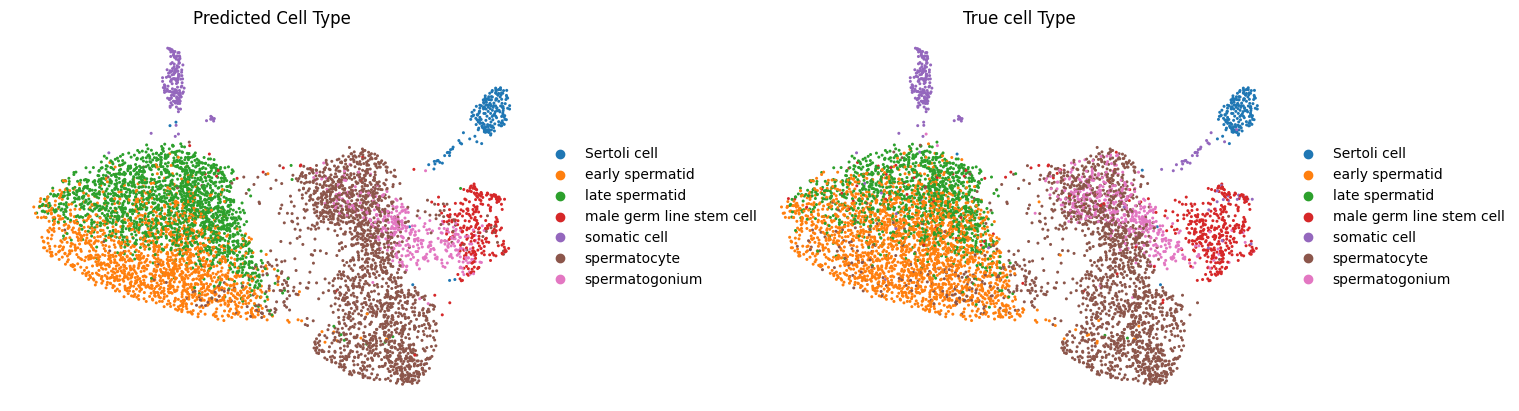

In [20]:
sc.pl.umap(
    adata_map, 
    color=['predicted_cell_type', "cell_type"], 
    ncols=2, 
    frameon=False,
    wspace=0.3,  # Add space between plots
    title=['Predicted Cell Type', 'True cell Type'],  # Add descriptive titles
)

We can also visualize that using a confusion matrix between predicted and true cell types.

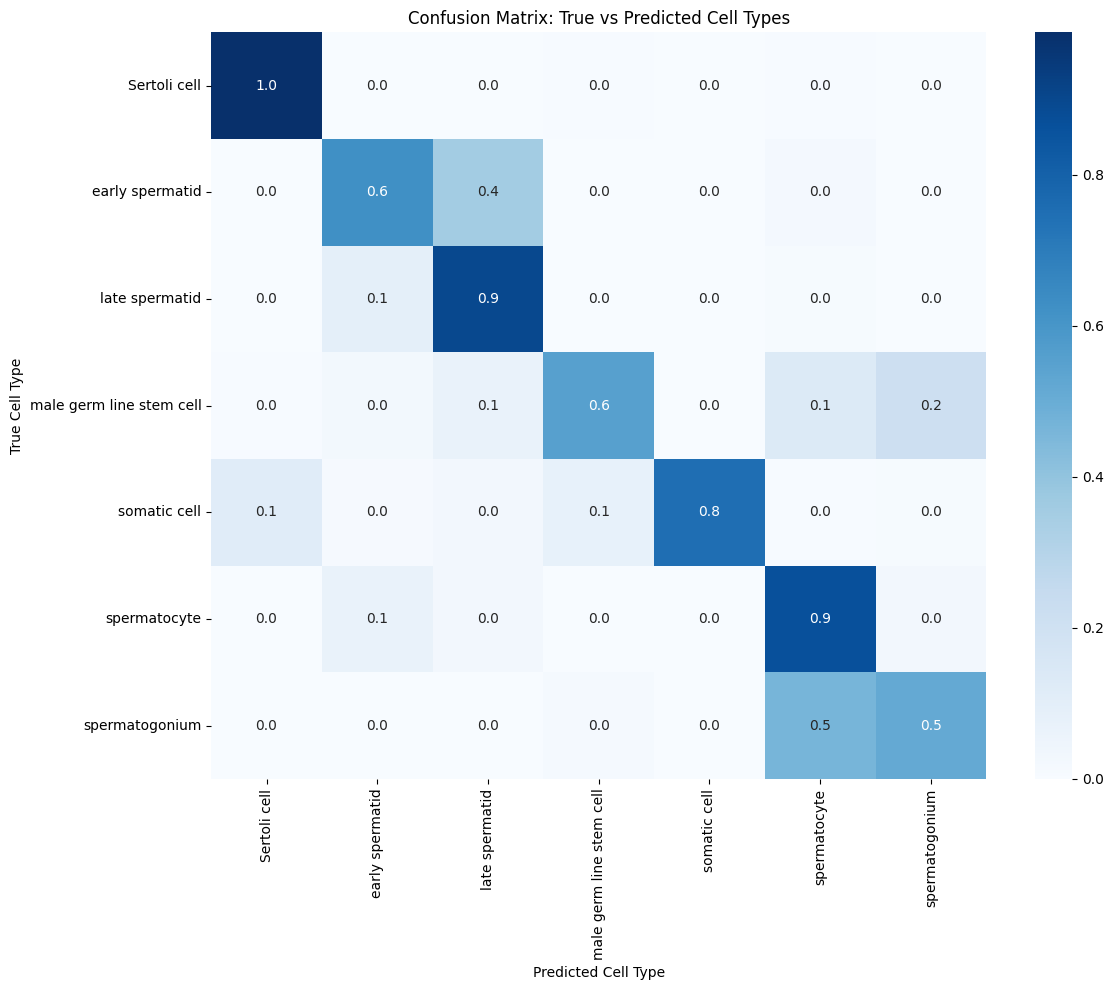

In [9]:
true_labels = adata_map.obs['cell_type']
pred_labels = adata_map.obs['predicted_cell_type']

# Get unique labels from both true and predicted
all_labels = np.unique(np.concatenate([true_labels.cat.categories, pred_labels.cat.categories]))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=all_labels)

# Normalize the confusion matrix by row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=all_labels, yticklabels=all_labels)
plt.xlabel('Predicted Cell Type')
plt.ylabel('True Cell Type')
plt.title('Confusion Matrix: True vs Predicted Cell Types')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


We can finally plot the embeddings of both datasets in the same UMAP space.

/work/venv/tf311/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


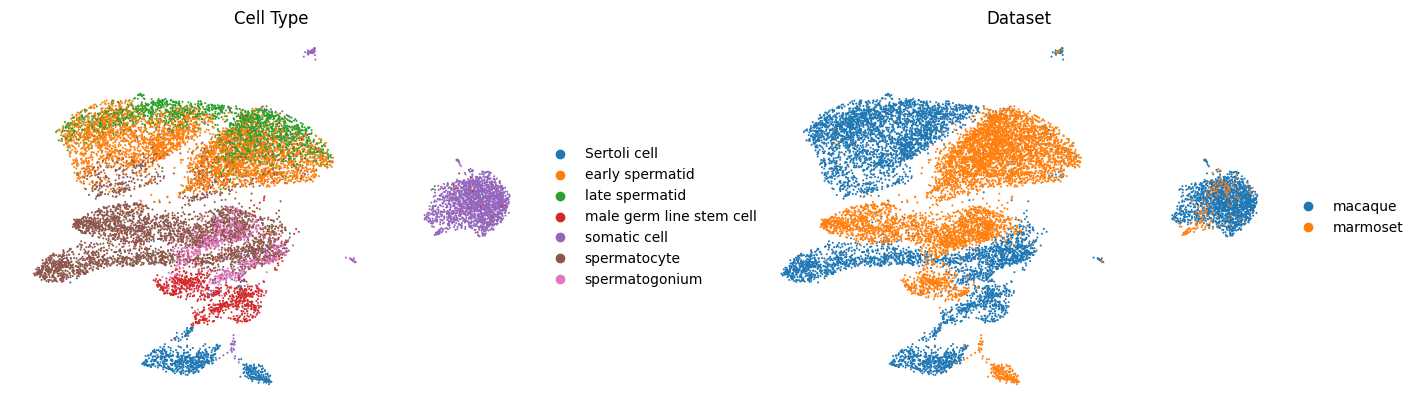

In [19]:
# Concatenate the AnnData objects
adata_joint = ad.concat(
    [adata_output, adata_map_output], 
    label="dataset", 
    keys=["macaque", "marmoset"], 
)

# Perform UMAP and plot
sc.pp.neighbors(adata_joint, use_rep="embeddings")
sc.tl.umap(adata_joint)
sc.pl.umap(
    adata_joint, 
    color=["cell_type", "dataset"], 
    ncols=2, 
    frameon=False,
    wspace=0.3,  # Add space between plots
    title=['Cell Type', 'Dataset'],  # Add descriptive titles
)